
#  Computing 3D PDF from State matrix and tag pressure information

## 1. **Configure the Notebook:**
Prepare the notebook to compute the 3D PDF.

In this step, we set up the notebook environment for analysis. It includes installing necessary packages, importing required libraries, setting up parameters, and configuring the cluster for distributed computing. It also retrieves the tag data needed for analysis.


In [15]:
# Import necessary libraries and modules.
import xarray as xr
from pangeo_fish.io import open_tag

In [2]:
# Set up execution parameters for the analysis.
# Note: This cell is tagged as parameters, allowing automatic updates when configuring with papermill.
# `tag_name` corresponds to the name of the biologging tag (DST identification number),

# which is also a path for storing all the information for the specific fish tagged with `tag_name`.
# `tag_root` specifies the root URL for tag data used for this computation.
tag_name = "A19124"

# `scratch_root` specifies the root directory for storing output files.
tag_root = "https://data-taos.ifremer.fr/data_tmp/cleaned/tag/"

# `storage_options` specifies options for the filesystem storing output files.
scratch_root = "s3://destine-gfts-data-lake/demo"

# If you are using a local file system, activate the following two lines:
storage_options = {
    "anon": False,
    "profile": "gfts",
    "client_kwargs": {
        "endpoint_url": "https://s3.gra.perf.cloud.ovh.net",
        "region_name": "gra",
    },
}

# scratch_root = "."
# storage_options = None


# Default chunk value for the time dimension. This value depends on the configuration of your Dask cluster.
chunk_time = 24


# Parameters for step 2: **Compare Reference Model with DST Information:**
# `bbox`, the bounding box, defines the latitude and longitude range for the analysis area.
# Define target root directories for storing analysis results.
bbox = {"latitude": [46, 51], "longitude": [-8, -1]}

In [3]:
# Define the default chunk size for optimization.
target_root = f"{scratch_root}/{tag_name}"

# Set up a local cluster for distributed computing.
default_chunk = {"time": chunk_time, "lat": -1, "lon": -1}
default_chunk_xy = {"time": chunk_time, "x": -1, "y": -1}

In [4]:
# Open and retrieve the tag data required for the analysis.
from distributed import LocalCluster

cluster = LocalCluster()
client = cluster.get_client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 3
Total threads: 6,Total memory: 24.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45093,Workers: 3
Dashboard: http://127.0.0.1:8787/status,Total threads: 6
Started: Just now,Total memory: 24.00 GiB
Comm: tcp://127.0.0.1:39093,Total threads: 2
Dashboard: http://127.0.0.1:44197/status,Memory: 8.00 GiB
Nanny: tcp://127.0.0.1:40623,


In [5]:
tag = open_tag(tag_root, tag_name)
tag

DataTree('None', parent=None)
│   Dimensions:  ()
│   Data variables:
│       *empty*
│   Attributes:
│       pit_tag_id:       A19124
│       acoustic_tag_id:  OPI-372
│       scientific_name:  Pollachius pollachius
│       common_name:      Pollock
│       project:          FISHINTEL
├── DataTree('dst')
│       Dimensions:      (time: 20680)
│       Coordinates:
│         * time         (time) datetime64[ns] 165kB 2022-06-12T22:00:00 ... 2022-07-...
│       Data variables:
│           temperature  (time) float64 165kB 17.58 17.53 17.5 ... 20.53 20.55 20.66
│           pressure     (time) float64 165kB 1.43 1.43 1.43 1.5 ... 1.81 1.81 1.81 1.81
├── DataTree('tagging_events')
│       Dimensions:     (event_name: 2)
│       Coordinates:
│         * event_name  (event_name) object 16B 'release' 'fish_death'
│       Data variables:
│           time        (event_name) datetime64[ns] 16B 2022-06-13T11:40:30 2022-06-2...
│           longitude   (event_name) float64 16B -5.098 -5.136
│           latitude    (event_name) float64 16B 48.45 48.43
├── DataTree('stations')
│       Dimensions:            (deployment_id: 41)
│       Coordinates:
│         * deployment_id      (deployment_id) int64 328B 28689 28690 ... 29666 59010
│       Data variables:
│           station_name       (deployment_id) object 328B 'ancrage_mahuda' ... 'stiff'
│           deploy_time        (deployment_id) datetime64[ns] 328B 2022-06-13T06:14:0...
│           deploy_longitude   (deployment_id) float64 328B -5.103 -5.112 ... -5.025
│           deploy_latitude    (deployment_id) float64 328B 48.45 48.45 ... 48.47 48.47
│           recover_time       (deployment_id) datetime64[ns] 328B 2022-06-20T14:07:0...
│           recover_longitude  (deployment_id) float64 328B nan nan nan ... nan nan nan
│           recover_latitude   (deployment_id) float64 328B nan nan nan ... nan nan nan
└── DataTree('acoustic')
        Dimensions:        (time: 48)
        Coordinates:
          * time           (time) datetime64[ns] 384B 2022-06-13T13:41:49 ... 2022-06...
        Data variables:
            deployment_id  (time) int64 384B 28689 28689 28690 ... 28690 28690 28690
            longitude      (time) float64 384B -5.103 -5.103 -5.112 ... -5.112 -5.112
            latitude       (time) float64 384B 48.45 48.45 48.45 ... 48.45 48.45 48.45


## 2. **Compute pdf_depth**

In this step, we compute the PDF only in depth for each time step used with the model. First, we load the reference model to choose the time bins used for creating the depth PDF (we can use the state matrix for that too).

**Note:** Here, the maximum depth is fixed at 42, and the interval is set at 2. This can be made 'automatic' or fixed according to the depth levels of our future climate data.


In [6]:
# Drop tag data outside the tagged events interval.
from pangeo_fish.cf import bounds_to_bins
from pangeo_fish.tags import reshape_by_bins, to_time_slice

In [7]:
time_slice = to_time_slice(tag["tagging_events/time"])
tag_log = tag["dst"].ds.sel(time=time_slice)

In [8]:
%%time
# Save probability distribution, state matrix.
states = xr.open_zarr(f"{target_root}/states.zarr")
states

CPU times: user 1.82 s, sys: 181 ms, total: 2 s
Wall time: 2.69 s


<xarray.Dataset> Size: 405MB
Dimensions:     (y: 294, x: 659, time: 258)
Coordinates:
    cell_ids    (y, x) int64 2MB dask.array<chunksize=(294, 659), meta=np.ndarray>
    latitude    (y, x) float64 2MB dask.array<chunksize=(294, 659), meta=np.ndarray>
    longitude   (y, x) float64 2MB dask.array<chunksize=(294, 659), meta=np.ndarray>
    resolution  float64 8B ...
  * time        (time) datetime64[ns] 2kB 2022-06-13T12:00:00 ... 2022-06-24T...
Dimensions without coordinates: y, x
Data variables:
    states      (time, y, x) float64 400MB dask.array<chunksize=(24, 294, 659), meta=np.ndarray>

In [9]:
%%time
# Reshape the tag log so that it bins to the time step of the reference model.
reshaped_tag = reshape_by_bins(
    tag_log,
    dim="time",
    bins=(
        states.cf.add_bounds(["time"], output_dim="bounds")
        .pipe(bounds_to_bins, bounds_dim="bounds")
        .get("time_bins")
    ),
    bin_dim="bincount",
    other_dim="obs",
).chunk({"time": chunk_time})
reshaped_tag

CPU times: user 449 ms, sys: 12.9 ms, total: 462 ms
Wall time: 455 ms


<xarray.Dataset> Size: 168kB
Dimensions:      (obs: 40, time: 258)
Coordinates:
  * obs          (obs) int64 320B 0 1 2 3 4 5 6 7 8 ... 32 33 34 35 36 37 38 39
  * time         (time) datetime64[ns] 2kB 2022-06-13T12:00:00 ... 2022-06-24...
    resolution   float64 8B ...
Data variables:
    temperature  (time, obs) float64 83kB dask.array<chunksize=(24, 40), meta=np.ndarray>
    pressure     (time, obs) float64 83kB dask.array<chunksize=(24, 40), meta=np.ndarray>

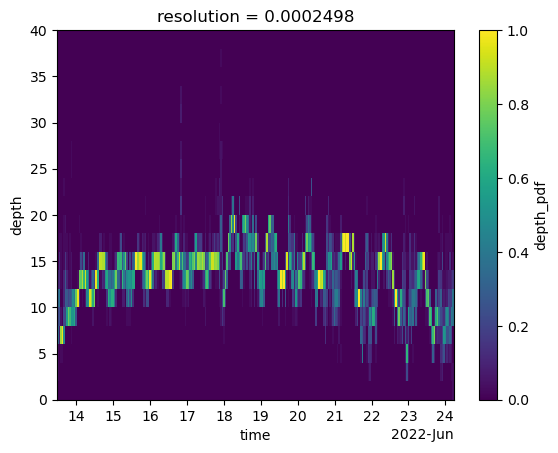

In [12]:
import numpy as np

maxdepth = 42
interval = 2
bins = np.arange(0, maxdepth, interval)


def compute_pdf(data, bins=np.arange(0, maxdepth, interval)):
    data = data[~np.isnan(data)]

    # Remove NaN values.
    hist, bin_edges = np.histogram(data, bins=bins, density=True)

    # Calculate the histogram.
    bin_width = bin_edges[1] - bin_edges[0]
    pdf = hist * bin_width
    return pdf  # , bin_edges


def compute_pdf_bins(bins=bins):
    # Normalize the histogram to ensure the sum of the PDF is 1.
    data = np.full(
        reshaped_tag.obs.size, 1.0
    )  # here i make fake dataset just to compute the bins and center of bins

    hist, bin_edges = np.histogram(data, bins=bins, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    return bin_edges, bin_centers


bin_edges, bin_centers = compute_pdf_bins()

depth_pdf = (
    xr.apply_ufunc(
        compute_pdf,  # the function
        reshaped_tag["pressure"],
        input_core_dims=[["obs"]],
        output_core_dims=[["depth"]],
        exclude_dims=set(("obs",)),
        vectorize=True,
        dask="parallelized",
        output_dtypes=[reshaped_tag.pressure.dtype],
        dask_gufunc_kwargs={
            "output_sizes": {
                "depth": bin_centers.size,
            }
        },
    )
    .assign_attrs({"long_name": "depth_pdf"})
    .to_dataset(name="depth_pdf")
    .assign_coords(depth=bin_centers)
)

depth_pdf
depth_pdf.depth_pdf.plot(x="time", y="depth")

In [11]:
depth_pdf

<xarray.Dataset> Size: 44kB
Dimensions:     (time: 258, depth: 20)
Coordinates:
  * time        (time) datetime64[ns] 2kB 2022-06-13T12:00:00 ... 2022-06-24T...
    resolution  float64 8B ...
  * depth       (depth) float64 160B 1.0 3.0 5.0 7.0 9.0 ... 33.0 35.0 37.0 39.0
Data variables:
    depth_pdf   (time, depth) float64 41kB dask.array<chunksize=(24, 20), meta=np.ndarray>

In [ ]:
%%time
# Remove NaN values.
depth_pdf.compute().to_zarr(
    f"{target_root}/depth_pdf.zarr",
    mode="w",
    consolidated=True,
    storage_options=storage_options,
)


## 3. **Compute 3D PDF**

Multiply the 2D map with the depth PDF to obtain the 3D PDF.  Plot and veirify the result.  


In [13]:
ds = states.states.chunk(chunks={"time": 24 * 2}) * depth_pdf.depth_pdf.chunk(
    chunks={"time": 24 * 2}
)
ds = ds.persist().assign_attrs({"long_name": "3D_pdf"}).to_dataset(name="3d_pdf")
ds

<xarray.Dataset> Size: 8GB
Dimensions:     (y: 294, x: 659, time: 258, depth: 20)
Coordinates:
    cell_ids    (y, x) int64 2MB dask.array<chunksize=(294, 659), meta=np.ndarray>
    latitude    (y, x) float64 2MB dask.array<chunksize=(294, 659), meta=np.ndarray>
    longitude   (y, x) float64 2MB dask.array<chunksize=(294, 659), meta=np.ndarray>
    resolution  float64 8B 0.0002498
  * time        (time) datetime64[ns] 2kB 2022-06-13T12:00:00 ... 2022-06-24T...
  * depth       (depth) float64 160B 1.0 3.0 5.0 7.0 9.0 ... 33.0 35.0 37.0 39.0
Dimensions without coordinates: y, x
Data variables:
    3d_pdf      (time, y, x, depth) float64 8GB dask.array<chunksize=(48, 294, 659, 20), meta=np.ndarray>

In [ ]:
%%time
# Calculate the histogram.
(
    ds.to_zarr(
        f"{target_root}/three_d_pdf.zarr",
        mode="w",
        consolidated=True,
        storage_options=storage_options,
    )
)

In [16]:
ds.hvplot.quadmesh(x="longitude", y="latitude", groupby=["time", "depth"])

:DynamicMap   [time,depth]
   :QuadMesh   [longitude,latitude]   (3d_pdf)

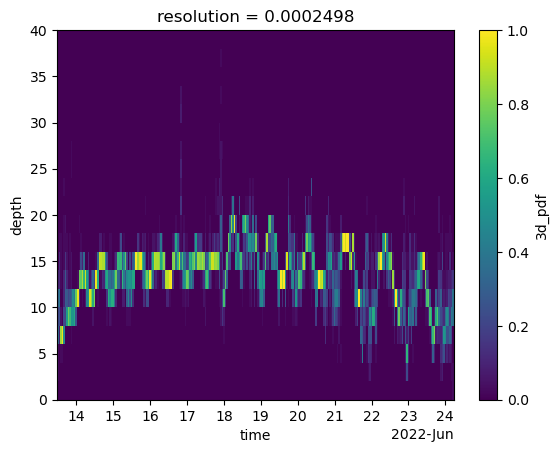

In [18]:
ds["3d_pdf"].sum(dim=["x", "y"]).plot(x="time", y="depth")